In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

import os
import mido
import pretty_midi as pm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

import tensorflow as tf
# import torch as pt
import joblib
import streamlit as st

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [22]:
def extract_basic_features(file_path):
    mid = mido.MidiFile(file_path)
    features = {
        'file_name': os.path.basename(file_path),
        'num_tracks': len(mid.tracks),
        'ticks_per_beat': mid.ticks_per_beat,
        'length': mid.length,
    }
    return features

def extract_pretty_midi_features(file_path):
    midi_data = pm.PrettyMIDI(file_path)
    features = {
        'num_notes': sum(len(instrument.notes) for instrument in midi_data.instruments),
        'note_density': sum(len(instrument.notes) for instrument in midi_data.instruments) / midi_data.get_end_time(),
        'avg_velocity': (sum(note.velocity for instrument in midi_data.instruments for note in instrument.notes) /
                         sum(len(instrument.notes) for instrument in midi_data.instruments)),
        'key_signature': None,
        'time_signature': None,
        'tempo': None
    }
    
    if midi_data.key_signature_changes:
        try:
            features['key_signature'] = midi_data.key_signature_changes[0].key_number
        except KeyError:
            features['key_signature'] = 'Unknown'
    
    if midi_data.time_signature_changes:
        features['time_signature'] = str(midi_data.time_signature_changes[0])
    
    if midi_data.get_tempo_changes()[1].size > 0:
        features['tempo'] = midi_data.get_tempo_changes()[1][0]
    
    return features

def get_composer_from_filename(file_path):
    return os.path.basename(file_path).split('_')[0]

def load_midi_files_to_dataframe(directory_path, composer):
    midi_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.mid')]
    data = []
    for file in midi_files:
        try:
            basic_features = extract_basic_features(file)
            pretty_midi_features = extract_pretty_midi_features(file)
            features = {**basic_features, **pretty_midi_features, 'composer': composer}
            data.append(features)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    df = pd.DataFrame(data)
    return df

# Specify the parent directory containing composer folders
parent_directory = 'C:\\Users\\gabri\\OneDrive\\Desktop\\MSAAI\\AAI-511\\aai-511_group1\\midiclassics'

# List of composers (folder names)
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Dictionary to hold DataFrames for each composer
composer_dataframes = {}

# Process each composer's folder
for composer in composers:
    composer_folder = os.path.join(parent_directory, composer)
    composer_df = load_midi_files_to_dataframe(composer_folder, composer)
    composer_dataframes[composer] = composer_df
    print(f"{composer} DataFrame:")
    print(composer_df.head())

# Merge all DataFrames into a single DataFrame
all_composers_df = pd.concat(composer_dataframes.values(), ignore_index=True)

# Display the merged DataFrame
print("Merged DataFrame:")
print(all_composers_df.head())

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Bach DataFrame:
                       file_name  num_tracks  ticks_per_beat      length  \
0                   AveMaria.mid           4             192  682.664062   
1  Bwv0525 Sonate en trio n1.mid           4             480  852.282011   
2  Bwv0526 Sonate en trio n2.mid           4             384  760.609070   
3  Bwv0527 Sonate en trio n3.mid           4             480  921.410553   
4  Bwv0528 Sonate en trio n4.mid           4             768  628.592614   

   num_notes  note_density  avg_velocity  key_signature       time_signature  \
0        793      9.670732     33.857503            NaN  4/4 at 0.00 seconds   
1       6077      7.132842     96.069442            NaN  4/4 at 0.00 seconds   
2       5379      7.074737     94.044990            NaN  4/4 at 0.00 seconds   
3       6056      6.579524     96.139696            NaN  2/4 at 0.00 seconds   
4       4221      6.718341     96.103293            NaN  4/4 at 0.00 seconds   

   tempo composer  
0  120.0     Bach  
1   75

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Beethoven DataFrame:
                      file_name  num_tracks  ticks_per_beat      length  \
0  32 Variations on a theme.mid           4             480  618.942806   
1        Andante in F Major.mid           3             192  250.500000   
2               Anh06 Rondo.mid           4             120  336.875269   
3  Anh08Nb1 Gavotte 4 hands.mid           6             120  167.176113   
4       Bagatella Fur Elise.mid           7             120  131.096678   

   num_notes  note_density  avg_velocity  key_signature       time_signature  \
0       7318     11.823386     69.349412            0.0  3/4 at 0.00 seconds   
1       4323     17.257485     52.873236            5.0  3/8 at 0.00 seconds   
2       4438     13.174015     77.954484           10.0  6/8 at 0.00 seconds   
3       1571      9.397276     63.513686            5.0  4/4 at 0.00 seconds   
4        950      7.246560     81.637895            0.0  3/4 at 0.00 seconds   

        tempo   composer  
0  120.000000  Beeth

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Chopin DataFrame:
                                           file_name  num_tracks  \
0   (2542)Prelude opus.28, No.16 in B flat minor.mid           2   
1  19 Polish Songs, for Solo Voice and Piano acco...           3   
2  19 Polish Songs, for Solo Voice and Piano acco...           3   
3  19 Polish Songs, for Solo Voice and Piano acco...           3   
4  19 Polish Songs, for Solo Voice and Piano acco...           3   

   ticks_per_beat      length  num_notes  note_density  avg_velocity  \
0            1024   64.000262       1199     18.734394     63.552961   
1             480  108.675018       1742     16.142204     97.889782   
2             480   58.162016        669     11.527386     87.372197   
3             480  122.586853        682      5.587330    100.079179   
4             480  241.889534       1062      4.391190    100.000000   

   key_signature       time_signature       tempo composer  
0           22.0  6/4 at 0.00 seconds  180.000180   Chopin  
1            NaN  

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Mozart DataFrame:
                           file_name  num_tracks  ticks_per_beat      length  \
0        A piece for Piano,K.176.mid           4             240  116.503280   
1               Adagio in B flat.mid           6             480  716.505484   
2  Another piece for Piano,K.176.mid           4             240  128.892212   
3                 Contradance n1.mid           3             120   34.904511   
4                 Contradance n2.mid           3             120   59.256950   

   num_notes  note_density  avg_velocity  key_signature       time_signature  \
0        881      7.577629     64.000000            NaN  3/4 at 0.00 seconds   
1       3332      4.650348     81.130552            2.0  4/4 at 0.00 seconds   
2       1139      8.836841     64.000000            NaN  3/4 at 0.00 seconds   
3        302      8.652177    127.000000            7.0  2/4 at 0.00 seconds   
4        378      6.378999    127.000000            9.0  2/4 at 0.00 seconds   

        tempo compos

In [23]:
all_composers_df.head()

,file_name,num_tracks,ticks_per_beat,length,num_notes,note_density,avg_velocity,key_signature,time_signature,tempo,composer
0,AveMaria.mid,4,192,682.664062,793,9.670732,33.857503,NaN,4/4 at 0.00 seconds,120.0,Bach
1,Bwv0525 Sonate en trio n1.mid,4,480,852.282011,6077,7.132842,96.069442,NaN,4/4 at 0.00 seconds,75.0,Bach
2,Bwv0526 Sonate en trio n2.mid,4,384,760.609070,5379,7.074737,94.044990,NaN,4/4 at 0.00 seconds,80.0,Bach
3,Bwv0527 Sonate en trio n3.mid,4,480,921.410553,6056,6.579524,96.139696,NaN,2/4 at 0.00 seconds,60.0,Bach
4,Bwv0528 Sonate en trio n4.mid,4,768,628.592614,4221,6.718341,96.103293,NaN,4/4 at 0.00 seconds,40.0,Bach


In [24]:
all_composers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       480 non-null    object 
 1   num_tracks      480 non-null    int64  
 2   ticks_per_beat  480 non-null    int64  
 3   length          480 non-null    float64
 4   num_notes       480 non-null    int64  
 5   note_density    480 non-null    float64
 6   avg_velocity    480 non-null    float64
 7   key_signature   364 non-null    float64
 8   time_signature  479 non-null    object 
 9   tempo           480 non-null    float64
 10  composer        480 non-null    object 
dtypes: float64(5), int64(3), object(3)
memory usage: 41.4+ KB


In [25]:
all_composers_df = all_composers_df.dropna()

In [26]:
all_composers_df.drop(columns='file_name', inplace=True)

In [27]:
all_composers_df.reset_index(drop=True, inplace=True)

In [28]:
all_composers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_tracks      364 non-null    int64  
 1   ticks_per_beat  364 non-null    int64  
 2   length          364 non-null    float64
 3   num_notes       364 non-null    int64  
 4   note_density    364 non-null    float64
 5   avg_velocity    364 non-null    float64
 6   key_signature   364 non-null    float64
 7   time_signature  364 non-null    object 
 8   tempo           364 non-null    float64
 9   composer        364 non-null    object 
dtypes: float64(5), int64(3), object(2)
memory usage: 28.6+ KB


In [36]:
all_composers_df.head()

,num_tracks,ticks_per_beat,length,num_notes,note_density,avg_velocity,key_signature,time_signature,tempo,composer
0,13,120,704.715792,7574,10.747595,70.126221,2.0,4/4 at 0.00 seconds,85.000043,Bach
1,6,240,370.254778,3049,8.234870,126.737947,0.0,4/4 at 0.00 seconds,100.000000,Bach
2,14,240,440.050492,4148,9.426191,108.330521,0.0,3/4 at 0.00 seconds,82.999950,Bach
3,15,240,642.463248,4365,6.794163,115.145934,0.0,4/4 at 0.00 seconds,62.999997,Bach
4,14,240,315.355429,2092,6.633785,93.714149,0.0,4/4 at 0.00 seconds,60.000000,Bach


In [37]:
all_composers_df['composer'].value_counts()

Beethoven    116
Chopin       102
Mozart        79
Bach          67
Name: composer, dtype: int64

Features and target assignment, encoding, Scaling, and reshaping data. 

In [38]:
features = all_composers_df.drop(columns='composer')
target = all_composers_df['composer']

In [39]:
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = features.select_dtypes(include=['object']).columns.tolist()

In [40]:
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(target)

In [43]:
column_transformer = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('categorical', OneHotEncoder(), categorical_features)
    ]
)

In [44]:
transformed_features = column_transformer.fit_transform(features)

In [45]:
reshaped_features = transformed_features.reshape(transformed_features.shape[0], 1, transformed_features.shape[1])

In [46]:
random_state = 88

In [116]:
features_train, features_test, target_train, target_test = train_test_split(reshaped_features, encoded_target, test_size=0.3, random_state=random_state )

Model Architecture

In [131]:
model = Sequential()

In [132]:
model.add(LSTM(50, activation='relu', input_shape=(1, transformed_features.shape[1])))
model.add(Dropout(0.2))

# Add dense layers
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(encoded_target)), activation='softmax'))

In [133]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [134]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                16000     
                                                                 
 dropout_31 (Dropout)        (None, 50)                0         
                                                                 
 dense_24 (Dense)            (None, 100)               5100      
                                                                 
 dropout_32 (Dropout)        (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 4)                 404       
                                                                 
Total params: 21,504
Trainable params: 21,504
Non-trainable params: 0
_________________________________________________________________


In [135]:
history = model.fit(features_train, target_train, epochs=70, batch_size=32, validation_data=(features_test, target_test))

Epoch 1/70
8/8 [==============================] - 1s 30ms/step - loss: 1.3786 - accuracy: 0.2874 - val_loss: 1.3699 - val_accuracy: 0.3545
Epoch 2/70
8/8 [==============================] - 0s 4ms/step - loss: 1.3618 - accuracy: 0.4055 - val_loss: 1.3553 - val_accuracy: 0.4727
Epoch 3/70
8/8 [==============================] - 0s 4ms/step - loss: 1.3460 - accuracy: 0.4370 - val_loss: 1.3406 - val_accuracy: 0.4818
Epoch 4/70
8/8 [==============================] - 0s 4ms/step - loss: 1.3240 - accuracy: 0.4567 - val_loss: 1.3234 - val_accuracy: 0.5000
Epoch 5/70
8/8 [==============================] - 0s 4ms/step - loss: 1.3074 - accuracy: 0.4567 - val_loss: 1.2999 - val_accuracy: 0.5000
Epoch 6/70
8/8 [==============================] - 0s 4ms/step - loss: 1.2692 - accuracy: 0.4764 - val_loss: 1.2726 - val_accuracy: 0.5000
Epoch 7/70
8/8 [==============================] - 0s 4ms/step - loss: 1.2417 - accuracy: 0.4882 - val_loss: 1.2396 - val_accuracy: 0.5000
Epoch 8/70
8/8 [=================

In [136]:
loss, accuracy = model.evaluate(features_test, target_test)
print(f'Test Accuracy: {accuracy:.4f}')

4/4 [==============================] - 0s 1ms/step - loss: 0.8672 - accuracy: 0.6455
Test Accuracy: 0.6455


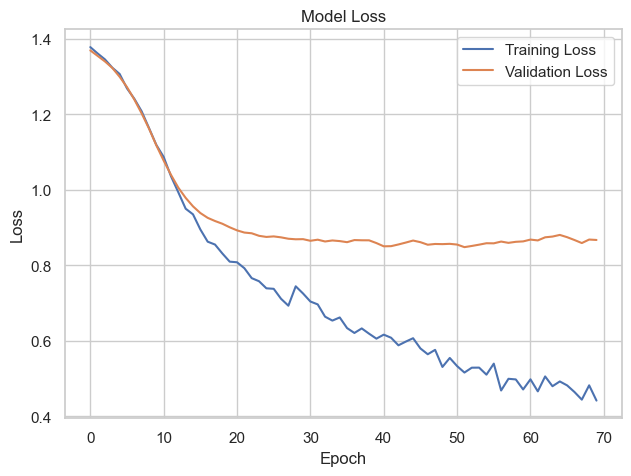

In [137]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Working on dashboard: 

In [141]:
joblib.dump(model, 'draft_lstm.pkl')

joblib.dump(column_transformer, 'column_transfomer.pkl')

INFO:tensorflow:Assets written to: ram://cf1854f2-ebe0-477e-ad42-152b23048b79/assets


['column_transfomer.pkl']

In [ ]:
modelo = load_model('draft_lstm.h5')